In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from pandas_profiling import ProfileReport
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import IsolationForest, RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, plot_confusion_matrix, plot_precision_recall_curve, precision_score, recall_score, f1_score
import shap


In [2]:
# Split data into train/test
df = pd.read_csv("data.csv", encoding="latin-1")
df_train, df_test = train_test_split(df, test_size=0.1, random_state=123)

In [4]:
df_train.head()

,ï»¿PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
75,15,0,50th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0
547,109,0,30th,0,0.0,0.0,0.0,0.0,1.0,0.0,...,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.000000,4-6,1
722,144,1,80th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.0,-1.0,-1.000000,-1.0,-1.000000,-1.000000,4-6,1
42,8,0,50th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.857143,-0.939394,-1.0,-1.0,-0.778626,-1.0,-0.859089,-0.940695,4-6,0
21,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-4,0


In [6]:
#### Perform exploratory data analysis, including outlier detection, no outliers detected
#### uncomment next two lines to see pandas profiling report for datset (takes a few minutes to run)
#profile = ProfileReport(df_train.sample(n=500),minimal=True) 
#profile.to_notebook_iframe()



dropping the features the following features:

-     ï»¿PATIENT_VISIT_IDENTIFIER: this feature is just a patient identifier and are all distinct, it will not give us any relevant information
- we drop ICU from our x_train because that's what we want to predict

In [7]:
df_train.columns
X_train = df_train.drop(columns=['ï»¿PATIENT_VISIT_IDENTIFIER','ICU'])
y_train = df_train['ICU']
X_test = df_test.drop(columns=['ï»¿PATIENT_VISIT_IDENTIFIER','ICU'])
y_test = df_test['ICU']


In [8]:
# building a preprocessing pipeline:
numeric_preprocessing = make_pipeline(SimpleImputer(strategy='median'), 
                                      StandardScaler())

categorical_preprocessing = make_pipeline(SimpleImputer(strategy='constant', fill_value="?"),
                                          OneHotEncoder(handle_unknown='ignore', sparse=False))

In [9]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = X_train.select_dtypes(include=numerics)

In [10]:
numeric_features= newdf.columns.tolist()
len(numeric_features)
remove_features = ['AGE_ABOVE65','GENDER']
for i in remove_features:
    numeric_features.remove(i)
    print(i)

AGE_ABOVE65
GENDER


In [12]:
cat = X_train.select_dtypes(exclude=numerics)
categorical= cat.columns.tolist()
categorical_features = ['AGE_ABOVE65','GENDER',
   'AGE_PERCENTIL', 'WINDOW']
X_train[categorical_features]

,AGE_ABOVE65,GENDER,AGE_PERCENTIL,WINDOW
75,0,0,50th,0-2
547,0,0,30th,4-6
722,1,0,80th,4-6
42,0,0,50th,4-6
21,0,0,10th,2-4
...,...,...,...,...
1122,1,1,60th,4-6
1346,0,0,20th,2-4
1406,1,1,90th,2-4
1389,0,0,10th,ABOVE_12


In [13]:
preprocessor = ColumnTransformer([
    ('numeric', numeric_preprocessing, numeric_features),
    ('categorical', categorical_preprocessing, categorical_features)
])

In [14]:
 preprocessor.fit(X_train);

Trying some models includng:
- DummyClassifer
- LogisticRegression
- LGBMClassifier

In [17]:
dc = DummyClassifier(strategy='prior')
dc.fit(X_train,y_train)
dc.score(X_train,y_train)


0.7297921478060047

In [16]:
dc.score(X_test,y_test)

0.7564766839378239

In [18]:
dc.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [19]:
dc.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [20]:
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
pipe.fit(X_train, y_train);

In [21]:
cv = cross_validate(pipe, X_train, y_train)
cv['test_score'].mean()

0.8573886825140346

In [22]:
pipe.score(X_test,y_test)

0.8601036269430051

In [25]:
pipe_lgbm = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier' , LGBMClassifier(random_state=999))
])

In [26]:
pipe_lgbm.fit(X_train,y_train);

In [27]:
cross_validate(pipe_lgbm, X_train, y_train)

{'fit_time': array([0.6806078 , 0.68812871, 0.75510716, 0.64497685, 0.67810369]),
 'score_time': array([0.03997493, 0.03656459, 0.03997302, 0.03124213, 0.03997326]),
 'test_score': array([0.88184438, 0.84726225, 0.88728324, 0.86127168, 0.89884393])}

In [28]:
pipe_lgbm.score(X_test,y_test)

0.8808290155440415

In [29]:
pipe_random_forest = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=999))])

In [30]:
cv_rf = cross_validate(pipe_random_forest, X_train,y_train)
cv_rf['test_score'].mean()

0.8689343839016509

In [31]:
pipe_random_forest.fit(X_train,y_train);

In [32]:
pipe_random_forest.score(X_train,y_train)

0.9901847575057737

In [33]:
pipe_random_forest.score(X_test,y_test)

0.8911917098445595

In [34]:
pipe_xgb = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier' , XGBClassifier(random_state=999))
])

In [35]:
pipe_xgb.fit(X_train,y_train);

In [36]:
cross_validate(pipe_xgb,X_train,y_train)

{'fit_time': array([0.70623398, 0.8027842 , 0.75477266, 0.70086551, 0.71003532]),
 'score_time': array([0.03197861, 0.03197956, 0.03124237, 0.03124094, 0.05323601]),
 'test_score': array([0.89913545, 0.85590778, 0.89017341, 0.87283237, 0.90751445])}

In [37]:
pipe_xgb.score(X_test,y_test)

0.8860103626943006

Hyperparameter tuning:

In [39]:
# selected Random Forest classifier for hyperparameter tuning because it had the best test score
param_choices = {'classifier__n_estimators': np.arange(25,125),
               'classifier__max_depth': np.arange(25,2000),
               'classifier__bootstrap': [True, False]}

In [40]:
random_search = RandomizedSearchCV(pipe_random_forest, param_choices,
                                   n_iter = 12, 
                                   verbose = 1,
                                   n_jobs = -1,
                                   random_state = 123)

In [41]:
random_search.fit(X_train, y_train);


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   15.3s finished


In [42]:
random_search.best_params_

{'classifier__n_estimators': 55,
 'classifier__max_depth': 305,
 'classifier__bootstrap': True}

In [43]:
pd.DataFrame(random_search.cv_results_)[['mean_test_score', 'param_classifier__n_estimators', 'param_classifier__max_depth','param_classifier__bootstrap', 'mean_fit_time', 'rank_test_score']].set_index("rank_test_score").sort_index()

,mean_test_score,param_classifier__n_estimators,param_classifier__max_depth,param_classifier__bootstrap,mean_fit_time
rank_test_score,,,,,
1,0.870675,55,305,True,1.103574
1,0.870675,55,202,True,1.017105
1,0.870675,55,1316,True,1.115142
4,0.870672,74,1489,True,1.261558
5,0.870095,99,253,False,2.080955
6,0.870094,75,1870,False,1.627017
7,0.870092,94,828,False,2.268580
8,0.868939,67,543,False,1.654655
9,0.868934,101,1949,True,1.717171


In [44]:
pipe_random_forest = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=55, max_depth= 305,bootstrap = True))
])

In [46]:
pipe_random_forest.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['DISEASE GROUPING 1',
                                                   'DISEASE GROUPING 2',
                                                   'DISEASE GROUPING 3',
                                                   'DISEASE GROUPING 4',
                                                   'DISEASE GROUPING 5',
                                                   'DISEASE GROUPING 6', 'HTN',
                                                   'IMMUNOCOMPROMISED', 'OTHER',
                    

In [47]:
pipe_random_forest.score(X_train,y_train)

0.9901847575057737

In [48]:
pipe_random_forest.score(X_test,y_test)

0.8963730569948186

Look at the sub-scores from the different folds of cross-validation

In [49]:
cv_forest = cross_validate(pipe_random_forest,X_train,y_train,cv=10)



In [50]:
cv_forest['test_score'].mean()

0.8695103315394326

In [51]:
cv_forest['test_score'].std()

0.016423614932157323

We can see that this model because it showed a reliable cross validation score with mean cv train score of 0.868 with a standard deviation of 0.027. However, from scoring the training data, we can see thta this model overfits as in 2.d we saw that we got a 99% accuracy in our training set. However, cross-validation seems reliable in this case and it is still our best scoring model out of the other classifiers we tried in 2.c

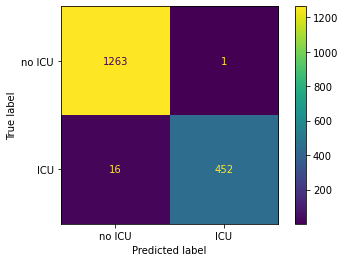

In [52]:
plot_confusion_matrix(pipe_random_forest, X_train, y_train, display_labels=['no ICU', 'ICU']);

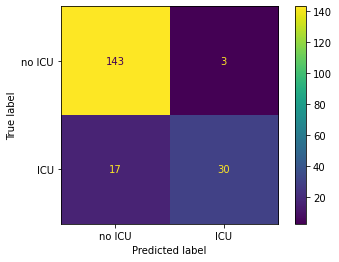

In [53]:
plot_confusion_matrix(pipe_random_forest, X_test, y_test, display_labels=['no ICU', 'ICU']);

In [54]:
precision_score(y_train, pipe_random_forest.predict(X_train))

0.9977924944812362

In [55]:
recall_score(y_train, pipe_random_forest.predict(X_train))

0.9658119658119658

In [56]:
from sklearn.metrics import plot_precision_recall_curve


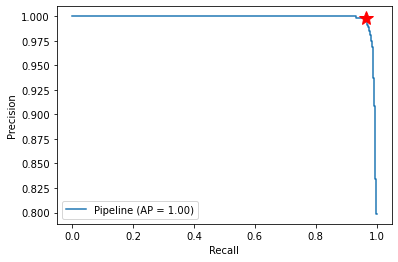

In [57]:
plot_precision_recall_curve(pipe_random_forest, X_train, y_train);
plt.plot(recall_score(y_train, pipe_random_forest.predict(X_train)),precision_score(y_train, pipe_random_forest.predict(X_train)), '*r', markersize=15);

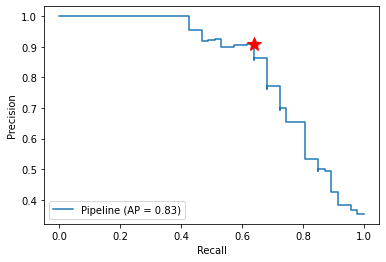

In [58]:
plot_precision_recall_curve(pipe_random_forest, X_test, y_test);
plt.plot(recall_score(y_test, pipe_random_forest.predict(X_test)),precision_score(y_test, pipe_random_forest.predict(X_test)), '*r', markersize=15);

In [59]:
recall_score(y_test, pipe_random_forest.predict(X_test))

0.6382978723404256

In [60]:
precision_score(y_test, pipe_random_forest.predict(X_test))

0.9090909090909091

In [61]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

In [62]:
roc_auc_score(y_train, pipe_random_forest.predict_proba(X_train)[:,1])

0.9992130869306503

In [63]:
cm = confusion_matrix(y_train, pipe_random_forest.predict(X_train))

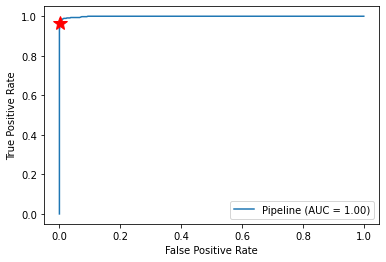

In [64]:
plot_roc_curve(pipe_random_forest, X_train, y_train);
plt.plot(cm[0,1]/(cm[0].sum()), cm[1,1]/(cm[1].sum()), '*r', markersize=15);

In [65]:
# importances = pipe_random_forest[1].feature_importances_
# std = np.std([tree.feature_importances_ for tree in  pipe_random_forest[1].estimators_],
#              axis=0)
# indices = np.argsort(importances)[::-1]

# # Print the feature ranking
# print("Feature ranking:")

# for f in range(X_train.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# # Plot the impurity-based feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(X_train.shape[1]), importances[indices],
#         color="r", yerr=std[indices], align="center")
# plt.xticks(range(X_train.shape[1]), indices)
# plt.xlim([-1, X_train.shape[1]])
# plt.show()

In [66]:
roc_auc_score(y_test, pipe_random_forest.predict_proba(X_test)[:,1])

0.9082628971145439

In [67]:
recall_score(y_test, pipe_random_forest.predict(X_test))

0.6382978723404256

In [68]:
precision_score(y_test, pipe_random_forest.predict(X_test))

0.9090909090909091

In [69]:
pipe_random_forest.score(X_test,y_test)

0.8963730569948186

In [70]:
explainer = shap.TreeExplainer(pipe_random_forest['classifier'])

In [71]:
preprocessing = ColumnTransformer([
    ('numeric', numeric_preprocessing, numeric_features),
    ('categorical', categorical_preprocessing, categorical_features)
])

In [72]:
preprocessing.fit(X_train);


In [73]:
preprocessing.named_transformers_['categorical']

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='?', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [74]:
ohe_columns = list(preprocessing.named_transformers_['categorical'].named_steps['onehotencoder'].get_feature_names(categorical_features))

In [75]:
new_columns = numeric_features + ohe_columns

In [76]:
X_train_enc = pd.DataFrame(preprocessing.transform(X_train), index=X_train.index, columns=new_columns)

In [77]:
rf = RandomForestClassifier(n_estimators=55, max_depth= 305,bootstrap = True)

In [78]:
rf.fit(X_train_enc,y_train)

RandomForestClassifier(max_depth=305, n_estimators=55)

In [79]:
rf.score(X_train_enc,y_train)

0.9901847575057737

In [80]:
shap_values = explainer.shap_values(X_train_enc) # this takes a couple minutes


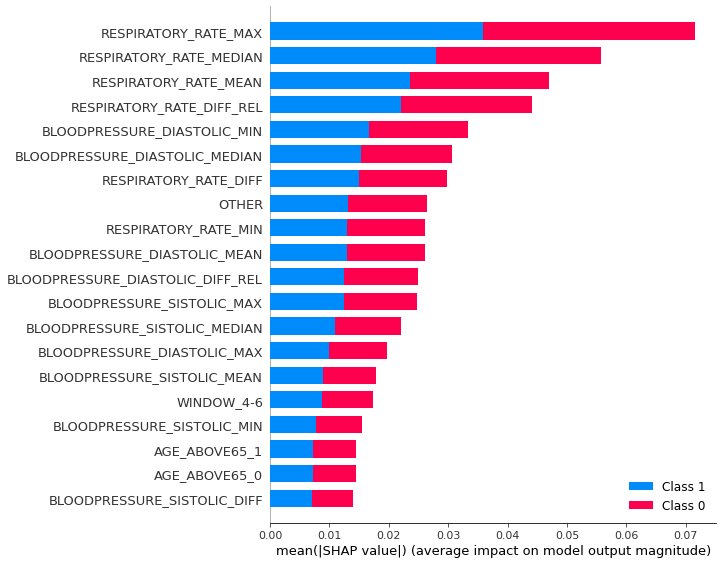

In [81]:
shap.summary_plot(shap_values, X_train_enc)

In [82]:
rf_importances = pd.DataFrame(data=rf.feature_importances_, index=new_columns, columns=["Importance"])


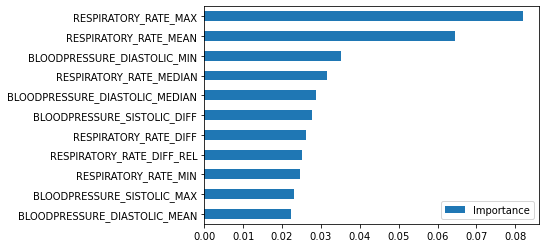

In [83]:
rf_importances.sort_values(by="Importance", ascending=False)[10::-1].plot.barh();

In [84]:
import matplotlib.pyplot as plt


In [85]:
n_estimators_values = [3, 10, 30, 100, 300]
scores_rf = []
scores_gb = []
for n in n_estimators_values:
    rf = RandomForestClassifier(n_estimators=n)
    rf.fit(X_train_enc,y_train)
    score_rf = rf.score(X_train_enc,y_train)
    scores_rf.append(score_rf)
    
    gb = GradientBoostingClassifier(n_estimators=n)
    gb.fit(X_train_enc,y_train)
    score_gb = gb.score(X_train_enc,y_train)
    scores_gb.append(score_gb)
    
    #score_gb = GradientBoostingClassifier(n_estimators=n).score(X_train_enc,y_train)
    #scores_gb.append(score_gb)
#plt.plot(max_depths, scores);
#plt.xlabel("max depth");
#plt.ylabel("accuracy score");

In [86]:
X_test_enc = pd.DataFrame(preprocessing.transform(X_test), index=X_test.index, columns=new_columns)

In [87]:
n_estimators_values = [10, 30, 100, 300]
scores_rf_test = []
scores_gb_test = []
for n in n_estimators_values:
    rf = RandomForestClassifier(n_estimators=n)
    rf.fit(X_test_enc,y_test)
    score_rf = rf.score(X_test_enc,y_test)
    scores_rf_test.append(score_rf)
    
    gb = GradientBoostingClassifier(n_estimators=n)
    gb.fit(X_test_enc,y_test)
    score_gb = gb.score(X_test_enc,y_test)
    scores_gb_test.append(score_gb)

In [88]:
print(scores_gb_test)
print(scores_rf_test)
print(scores_rf)
print(scores_gb)

[0.9378238341968912, 0.9792746113989638, 1.0, 1.0]
[0.9844559585492227, 0.9948186528497409, 1.0, 1.0]
[0.9647806004618937, 0.9797921478060047, 0.9896073903002309, 0.9901847575057737, 0.9901847575057737]
[0.7297921478060047, 0.874133949191686, 0.9064665127020786, 0.9463048498845266, 0.9763279445727483]


In [89]:
scores_rf_test

[0.9844559585492227, 0.9948186528497409, 1.0, 1.0]

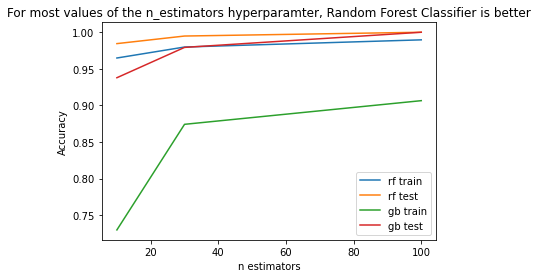

In [91]:
nmax = 3
plt.plot(n_estimators_values[:nmax], scores_rf[:nmax], label="rf train")
plt.plot(n_estimators_values[:nmax], scores_rf_test[:nmax],  label="rf test")
plt.plot(n_estimators_values[:nmax], scores_gb[:nmax], label="gb train")
plt.plot(n_estimators_values[:nmax], scores_gb_test[:nmax],  label="gb test")
plt.xlabel("n estimators");
plt.ylabel("Accuracy");
plt.legend();
plt.title("For most values of the n_estimators hyperparamter, Random Forest Classifier is better");

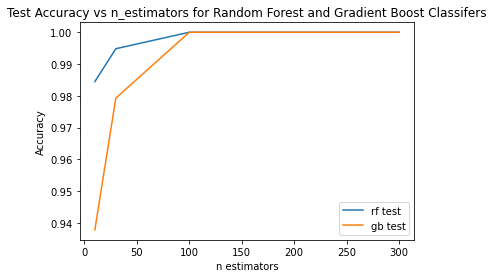

In [92]:
plt.plot(n_estimators_values, scores_rf_test,  label="rf test")
plt.plot(n_estimators_values, scores_gb_test,  label="gb test")
plt.xlabel("n estimators");
plt.ylabel("Accuracy");
plt.legend();
plt.title("Test Accuracy vs n_estimators for Random Forest and Gradient Boost Classifers");

Our model scores well with auc, precision and test accuracy. However, the recall score is quite bad so our false negative rate is high. Unfortunately, this mean that our model might not be robust/reliable in deployment. It is important in the context of our dataset that we minimize false negatives because it underpedicts our "decision" of allocating or increasing ICU resources. Therefore, there is in reality, more patients that need to be admitted to the ICU than what our model predicts.